<a href="https://colab.research.google.com/github/harshita23sharma/Colab_Notebooks/blob/master/TransferLearning_102Flower_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
tf.__version__


'2.0.0-dev20191002'

In [0]:
### Dataset link http://www.robots.ox.ac.uk/~vgg/data/flowers/102/

In [3]:
ll 102flowers/*

ls: cannot access '102flowers/*': No such file or directory


### Loading the TF_FLOWERS dataset


In [0]:
# !wget http://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz

In [0]:
# from IPython import display
# import glob
# import numpy as np
# import os
# %matplotlib inline

# if not os.path.exists('102flowers'):
#     !mkdir 102flowers
#     !tar zxvf 102flowers.tgz.1 -C ./102flowers/
# display.clear_output()

In [0]:
# from google.colab import files 
# uploaded = files.upload()

In [0]:
# import rarfile
# file_name = 'DataFolder.rar'

# with rarfile.RarFile(file_name,'r') as rar:
#   rar.extractall()
#   print('Done')


In [0]:
# !pip install tf-nightly-2.0-preview

In [0]:
### REF : https://www.back-prop.com/deep_learning/inceptionv3/tf_flowers/feature_extraction/fine_tuning/google_colab/2019/05/17/InceptionV3_TFFLOWERS/

In [0]:
import tensorflow_datasets as tfds
#The tf_flowers dataset is not partitioned into train, test and validation by default.
# To do that we can use the tfds.Split.TRAIN.subsplit function. 

# This expects a tuple indicating the split ratio like so (8,1,1). 
# This splits the data into 80%, 10% and 10% ratio for train, validation and test sets.
SPLIT_WEIGHTS = (8,1,1)
splits = tfds.Split.TRAIN.subsplit(weighted=SPLIT_WEIGHTS)




### Downloading dataset with tfds

In [0]:
#We can use tfds.load() function to load the dataset and split it as well. 
# the load function has the following options.


# tfds.load(
#     name,
#     split=None,
#     data_dir=None,
#     batch_size=1,
#     download=True,
#     as_supervised=False,
#     with_info=False,
#     builder_kwargs=None,
#     download_and_prepare_kwargs=None,
#     as_dataset_kwargs=None,
#     try_gcs=False
# )

# with_info=True gives us the metadata about the dataset

# as_supervised=True returns the data and label as a tuple (input, label)

In [11]:
(raw_train,raw_val,raw_test),metadata = tfds.load('tf_flowers',
                                                 split=list(splits),
                                                 data_dir="102flowers",
                                                  download=True,
                                                 as_supervised=True,
                                                 with_info=True)

### Try with download = True, How to use dataset which is not in tfds, can we download that?

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Dataset tf_flowers downloaded and prepared to 102flowers/tf_flowers/1.0.0. Subsequent calls will reuse this data.


### Build your Pipeline

In [0]:
def resize_normalize(image,label):
  
  image = tf.cast(image,tf.float32)
  
  image = tf.image.resize(image,(IMG_SIZE,IMG_SIZE))
  
  image = image / 255.0
  
  return image,label

def augment(image, label):
  
  image = tf.image.random_flip_left_right(image)
  
  image = tf.image.random_contrast(image, lower=0.0, upper=1.0)
  
  return image,label

In [0]:
IMG_SIZE = 128
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

train = raw_train.map(resize_normalize)
val = raw_val.map(resize_normalize)
test = raw_test.map(resize_normalize)

In [0]:
train = train.map(augment)


In [0]:
SHUFFLE_BUFFER_SIZE = 1024
BATCH_SIZE = 32

train = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
val = val.batch(BATCH_SIZE)
test = test.batch(BATCH_SIZE)
train = train.prefetch(tf.data.experimental.AUTOTUNE)


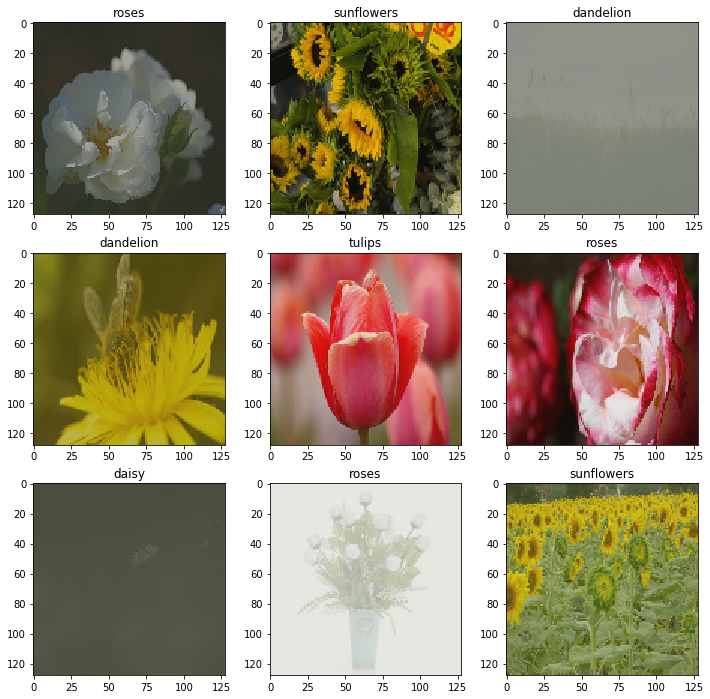

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

get_label_name = metadata.features['label'].int2str

plt.figure(figsize=(12,12)) 
for btch in train.take(1):
  for i in range(9):
    img,lbl = btch[0][i],btch[1][i]
    plt.subplot(3,3,i+1)
    plt.title(get_label_name(lbl.numpy()))
    plt.imshow(img)
plt.show()

In [17]:
metadata

tfds.core.DatasetInfo(
    name='tf_flowers',
    version=1.0.0,
    description='A large set of images of flowers',
    urls=['http://download.tensorflow.org/example_images/flower_photos.tgz'],
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
    }),
    total_num_examples=3670,
    splits={
        'train': 3670,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
    redistribution_info=,
)

In [0]:
#from tensorflow.keras.preprocessing.image import ImageDataGenerator

# TRAIN_DIR= './flower_data/train/'
# VAL_DIR= './flower_data/val/'

# train_datagen = ImageDataGenerator(
#     preprocessing_function=preprocess_input)
# train_generator = train_datagen.flow_from_directory(TRAIN_DIR,
#                                                     target_size=(HEIGHT,WIDTH),
#                                                    batch_size=BATCH_SIZE)

# valid_datagen = ImageDataGenerator(
#     preprocessing_function=preprocess_input)
# valid_generator = valid_datagen.flow_from_directory(VAL_DIR,
#                                                    target_size=(HEIGHT,WIDTH))

In [0]:
# from tensorflow.keras.applications import DenseNet121
# from tensorflow.keras.applications.densenet import preprocess_input
# HEIGHT=224
# WIDTH=224
# BATCH_SIZE=32

# basemodel = DenseNet121(weights='imagenet',
#                         include_top=False,
#                        input_shape=(HEIGHT,WIDTH,3))